In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import keras

Using TensorFlow backend.
C:\Users\Patron\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Patron\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Patron\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Patron\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [16]:
from numpy import loadtxt
from keras.models import load_model
model = load_model("model-no-shuflle.final")
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 11, 1024)          1579008   
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 1024)          4096      
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               983808    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)               

In [4]:
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [17]:
train_df = train
train_df.head(20)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


C:\Users\Patron\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


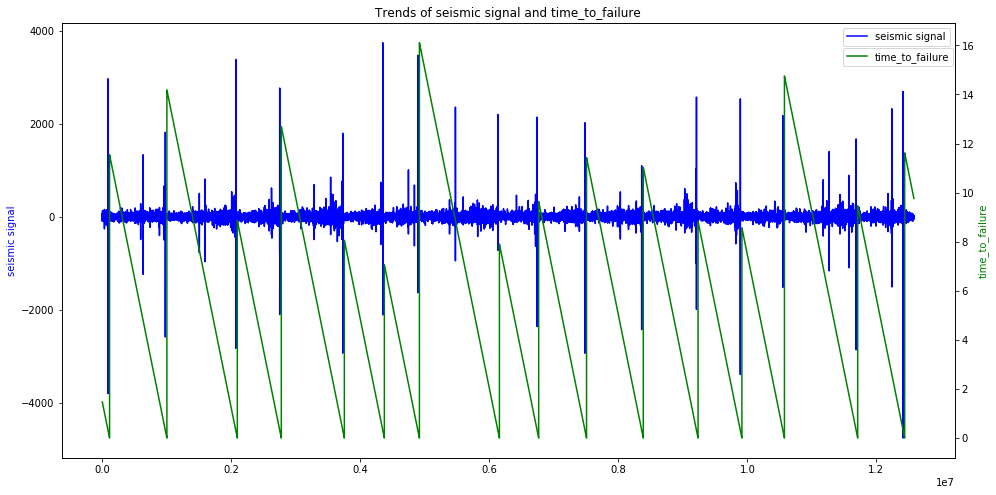

In [49]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of seismic signal and time_to_failure")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('seismic signal', color='b')
plt.legend(['seismic signal'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

C:\Users\Patron\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


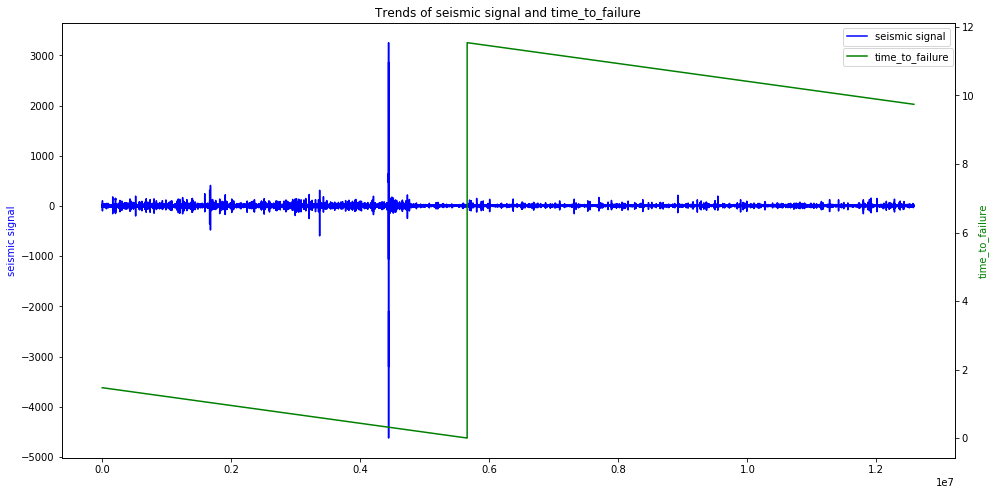

In [50]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of seismic signal and time_to_failure")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('seismic signal', color='b')
plt.legend(['seismic signal'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

In [6]:
chunk_size = 150000

chunks = int(np.floor(train_df.shape[0]/chunk_size))

X_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['min','max','std', 'avg', 'sum', 'median', 'mean_diff', 
                                                                       'q05', 'q25', 'q75', 'q95'])
y_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['ttf'])

def create_features(data_chunk, X_df, chunk_no, col_name='acoustic_data'):
    x = data_chunk[col_name]
    X_df.loc[chunk_no, 'min'] = x.min()
    X_df.loc[chunk_no, 'max'] = x.max()
    X_df.loc[chunk_no, 'std'] = x.std()
    X_df.loc[chunk_no, 'avg'] = x.mean()
    X_df.loc[chunk_no, 'sum'] = x.sum()
    X_df.loc[chunk_no, 'median'] = x.median()
    X_df.loc[chunk_no, 'mean_diff'] = np.mean(np.diff(x))
    X_df.loc[chunk_no, 'q05'] = np.quantile(x, 0.05)
    X_df.loc[chunk_no, 'q25'] = np.quantile(x, 0.25)
    X_df.loc[chunk_no, 'q75'] = np.quantile(x, 0.75)
    X_df.loc[chunk_no, 'q95'] = np.quantile(x, 0.95)
    return X_df

In [7]:
from tqdm import tqdm
for chunk_no in tqdm(range(chunks)):
    data_chunk = train_df.iloc[chunk_no*chunk_size:chunk_no*chunk_size+chunk_size]
    X_data = create_features(data_chunk, X_data, chunk_no)
    y = data_chunk['time_to_failure'].values[-1]
    y_data.loc[chunk_no, 'ttf'] = y

100%|██████████████████████████████████████████████████████████████████████████████| 4194/4194 [00:46<00:00, 90.72it/s]


In [8]:
print(X_data.shape)
print(y_data.shape)
print(X_data.shape[1])
X_data.head()


(4194, 11)
(4194, 1)
11


,min,max,std,avg,sum,median,mean_diff,q05,q25,q75,q95
0,-98.0,104.0,5.101106,4.884113,732617.0,5.0,-0.000080,-2.0,3.0,7.0,11.0
1,-154.0,181.0,6.588824,4.725767,708865.0,5.0,0.000000,-2.0,2.0,7.0,12.0
2,-106.0,140.0,6.967397,4.906394,735959.0,5.0,-0.000013,-3.0,2.0,7.0,13.0
3,-199.0,197.0,6.922305,4.902240,735336.0,5.0,0.000000,-2.0,2.0,7.0,12.0
4,-126.0,145.0,7.301110,4.908720,736308.0,5.0,-0.000007,-2.0,2.0,7.0,12.0


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, test_size=0.2)
# X_test
# X_data.values
X_train.shape


(3355, 11)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional, GRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization


#keras.layers.GRU(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=2, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, reset_after=False)

model = Sequential()
model.add((GRU(512, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1), return_sequences = True,recurrent_dropout = 0.2)))
#model.add(CuDNNGRU(64, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(GRU(256, recurrent_dropout = 0.3))
#model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.20))
# model.add(Flatten())
model.add(Dense(1))


In [21]:
# Reshaping for fit
# X_train_array = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train_array = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train_array = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

print(X_train_array.shape)
print(y_train_array.shape)

(3355, 11, 1)
(3355, 1, 1)


In [22]:
# model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["mse"])
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=["mae", "mse"])
#model.summary()

build = model.fit(X_train_array, y_train, epochs=150, batch_size=30, validation_split = 0.20, verbose=1, shuffle = False)

Train on 2684 samples, validate on 671 samples
Epoch 1/150
2684/2684 [==============================] - 23s 9ms/step - loss: 4.1919 - mae: 4.1919 - mse: 28.7094 - val_loss: 4.5781 - val_mae: 4.5781 - val_mse: 32.4325
Epoch 2/150
2684/2684 [==============================] - 21s 8ms/step - loss: 3.1150 - mae: 3.1150 - mse: 15.8882 - val_loss: 3.5321 - val_mae: 3.5321 - val_mse: 20.4149
Epoch 3/150
2684/2684 [==============================] - 20s 7ms/step - loss: 2.9021 - mae: 2.9021 - mse: 13.5103 - val_loss: 3.0794 - val_mae: 3.0794 - val_mse: 15.4211
Epoch 4/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.8603 - mae: 2.8603 - mse: 13.0842 - val_loss: 2.9577 - val_mae: 2.9577 - val_mse: 14.0166
Epoch 5/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.8215 - mae: 2.8215 - mse: 12.9838 - val_loss: 2.8963 - val_mae: 2.8963 - val_mse: 13.1918
Epoch 6/150
2684/2684 [==============================] - 23s 9ms/step - loss: 2.8808 - mae: 2.8808 - ms

Epoch 49/150
2684/2684 [==============================] - 21s 8ms/step - loss: 2.3830 - mae: 2.3830 - mse: 9.5690 - val_loss: 2.4210 - val_mae: 2.4210 - val_mse: 10.1952
Epoch 50/150
2684/2684 [==============================] - 21s 8ms/step - loss: 2.3813 - mae: 2.3813 - mse: 9.5385 - val_loss: 2.4157 - val_mae: 2.4157 - val_mse: 10.2006
Epoch 51/150
2684/2684 [==============================] - 21s 8ms/step - loss: 2.3733 - mae: 2.3733 - mse: 9.5823 - val_loss: 2.3976 - val_mae: 2.3976 - val_mse: 10.0843
Epoch 52/150
2684/2684 [==============================] - 21s 8ms/step - loss: 2.3662 - mae: 2.3662 - mse: 9.6014 - val_loss: 2.3666 - val_mae: 2.3666 - val_mse: 9.8339
Epoch 53/150
2684/2684 [==============================] - 21s 8ms/step - loss: 2.3422 - mae: 2.3422 - mse: 9.3232 - val_loss: 2.3622 - val_mae: 2.3622 - val_mse: 9.8123
Epoch 54/150
2684/2684 [==============================] - 21s 8ms/step - loss: 2.3631 - mae: 2.3631 - mse: 9.5001 - val_loss: 2.3571 - val_mae: 2.3571 -

2684/2684 [==============================] - 20s 8ms/step - loss: 2.2269 - mae: 2.2269 - mse: 8.5949 - val_loss: 2.2417 - val_mae: 2.2417 - val_mse: 9.1684
Epoch 98/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.1912 - mae: 2.1912 - mse: 8.3186 - val_loss: 2.2388 - val_mae: 2.2388 - val_mse: 9.1495
Epoch 99/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.1949 - mae: 2.1949 - mse: 8.4441 - val_loss: 2.2067 - val_mae: 2.2067 - val_mse: 8.8932
Epoch 100/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.2097 - mae: 2.2097 - mse: 8.4093 - val_loss: 2.2087 - val_mae: 2.2087 - val_mse: 8.9027
Epoch 101/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.1759 - mae: 2.1759 - mse: 8.2435 - val_loss: 2.2344 - val_mae: 2.2344 - val_mse: 9.1058
Epoch 102/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.2085 - mae: 2.2085 - mse: 8.5112 - val_loss: 2.2181 - val_mae: 2.2181 - val_mse: 8.9

2684/2684 [==============================] - 20s 8ms/step - loss: 2.1975 - mae: 2.1975 - mse: 8.3806 - val_loss: 2.1506 - val_mae: 2.1506 - val_mse: 8.4284
Epoch 146/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.1952 - mae: 2.1952 - mse: 8.3524 - val_loss: 2.1412 - val_mae: 2.1412 - val_mse: 8.3446
Epoch 147/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.2131 - mae: 2.2131 - mse: 8.5004 - val_loss: 2.1658 - val_mae: 2.1658 - val_mse: 8.5689
Epoch 148/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.1873 - mae: 2.1873 - mse: 8.3258 - val_loss: 2.1573 - val_mae: 2.1573 - val_mse: 8.4936
Epoch 149/150
2684/2684 [==============================] - 20s 8ms/step - loss: 2.1883 - mae: 2.1883 - mse: 8.3837 - val_loss: 2.1451 - val_mae: 2.1451 - val_mse: 8.3811
Epoch 150/150
2684/2684 [==============================] - 21s 8ms/step - loss: 2.2087 - mae: 2.2087 - mse: 8.3971 - val_loss: 2.1421 - val_mae: 2.1421 - val_mse: 8

In [25]:
import locale
locale.setlocale(locale.LC_ALL, '')
code = locale.getpreferredencoding()

In [27]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

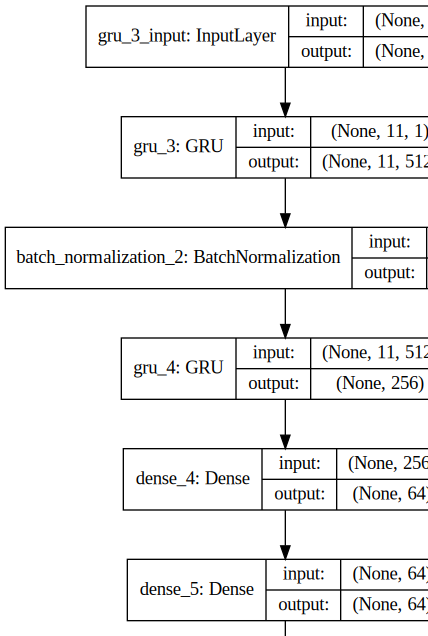

In [28]:
import pydot
import os

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

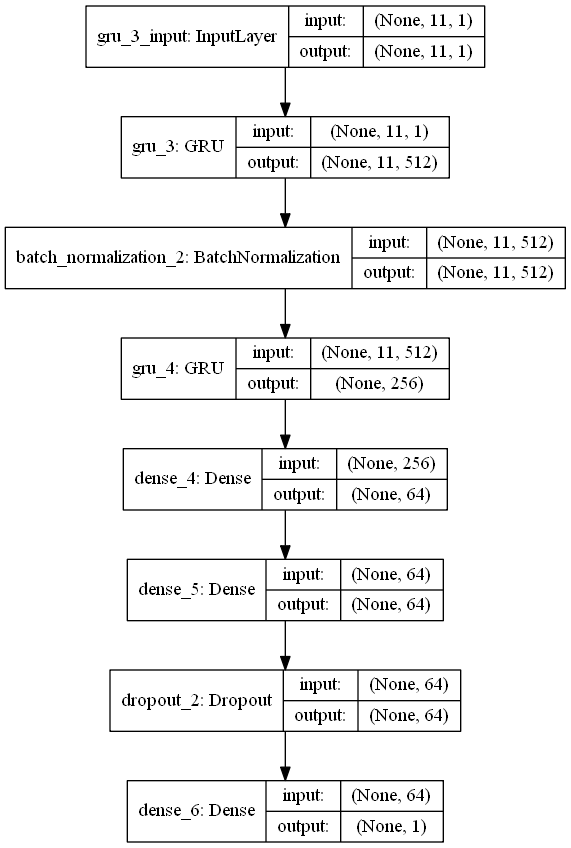

In [30]:

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 11, 512)           789504    
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 512)           2048      
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               590592    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

dict_keys(['val_loss', 'val_mae', 'val_mse', 'loss', 'mae', 'mse'])


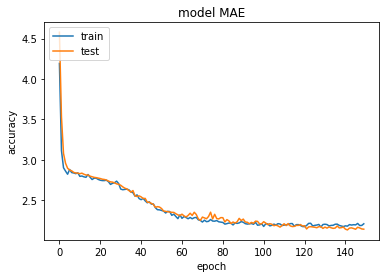

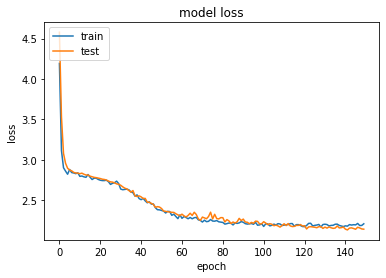

In [32]:
import matplotlib.pyplot as plt
# list all data in history
print(build.history.keys())
# summarize history for accuracy
plt.plot(build.history['mae'])
plt.plot(build.history['val_mae'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(build.history['loss'])
plt.plot(build.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
model.save("model-no-shuflle.final")
print("Saved model to disk")

Saved model to disk


In [34]:
submission = pd.read_csv("sample_submission.csv", index_col='seg_id', dtype={"time_to_failure": np.float32})
X_sub = pd.DataFrame(columns=X_data.columns, dtype=np.float32)

for i, seg_id in enumerate(tqdm(submission.index)):
    seg = pd.read_csv('test/' + str(seg_id) + '.csv')
    X_seg = create_features(seg, X_sub, i)

100%|██████████████████████████████████████████████████████████████████████████████| 2624/2624 [01:58<00:00, 22.23it/s]


In [30]:
X_seg_array = np.reshape(X_seg.values, (X_seg.shape[0], X_seg.shape[1], 1))
pred_final = model.predict(X_seg_array)
submission['time_to_failure'] = pred_final

submission.to_csv('submission-LSTM.csv')

            time_to_failure
seg_id                     
seg_004314         0.849007
seg_26a2a0         0.313333
seg_2f86cd         0.473670
seg_39ad50         0.775455
seg_3e87b4         0.923489
seg_724df9         0.263926
seg_7848f8         0.356415
seg_7a9f2b         0.343983
seg_7fa6ec         0.308729
seg_aa98cc         0.311698
seg_b35174         0.319333
seg_b686e5         0.803519
seg_bfdd14         0.878438
seg_c243a6         0.996716
seg_c5dee4         0.980307
seg_c80857         0.286766
seg_e3d751         0.236633
<class 'pandas.core.frame.DataFrame'>
Index(['time_to_failure'], dtype='object')
seg_004314
seg_26a2a0
seg_2f86cd
seg_39ad50
seg_3e87b4
seg_724df9
seg_7848f8
seg_7a9f2b
seg_7fa6ec
seg_aa98cc
seg_b35174
seg_b686e5
seg_bfdd14
seg_c243a6
seg_c5dee4
seg_c80857
seg_e3d751


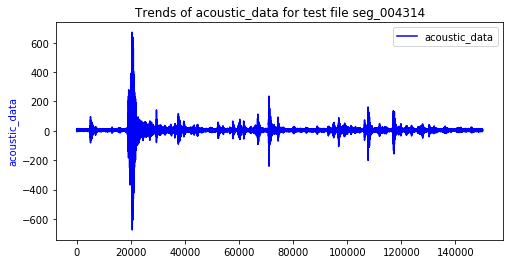

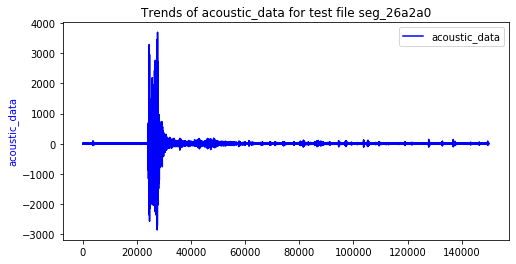

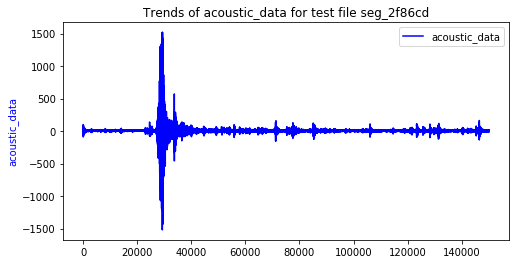

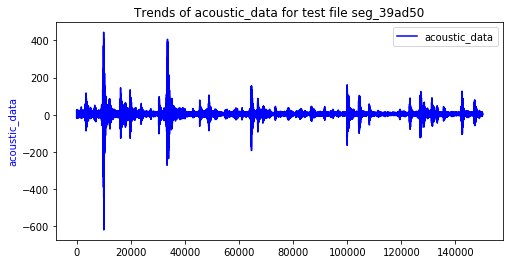

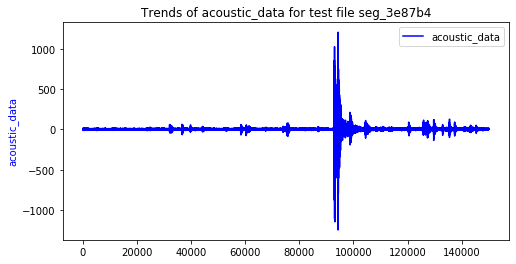

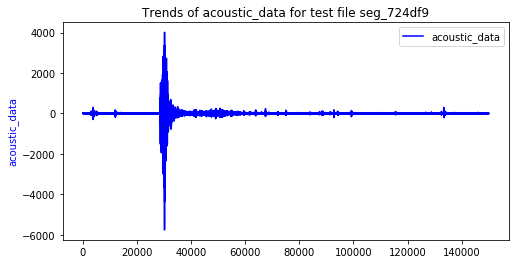

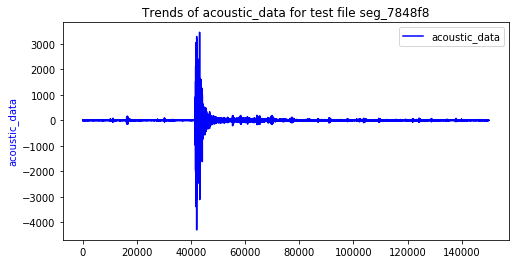

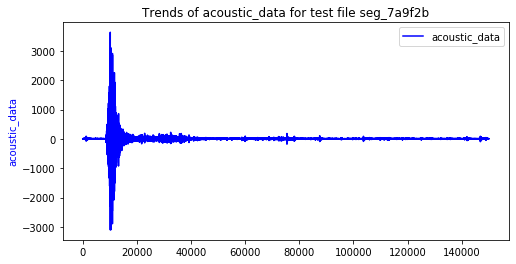

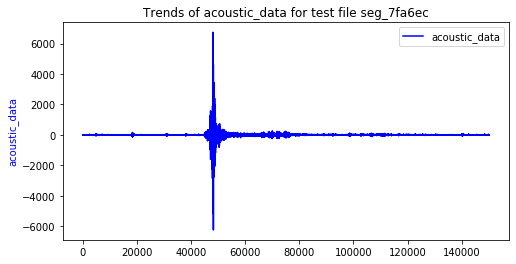

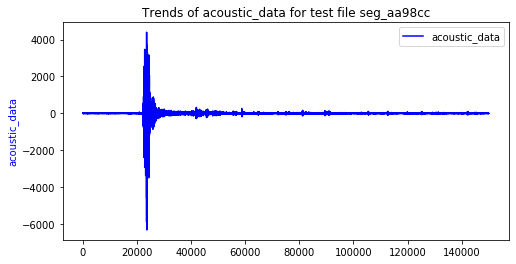

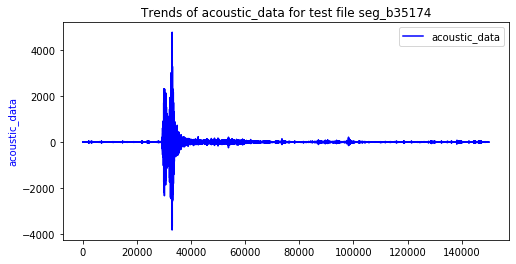

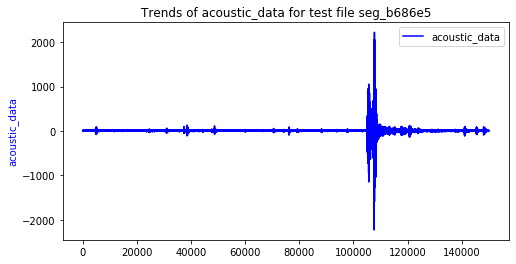

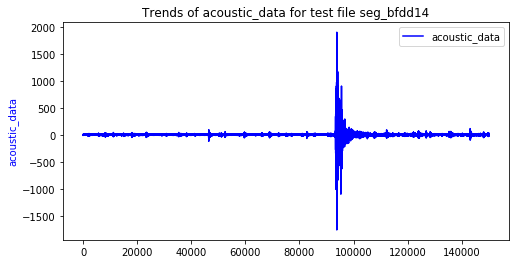

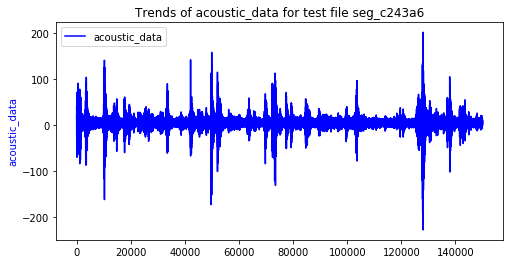

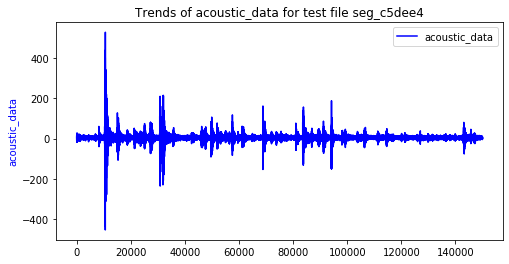

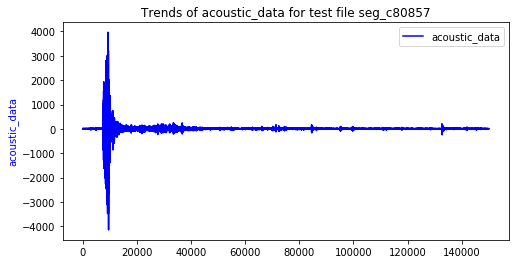

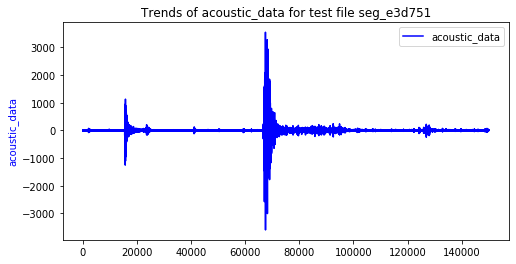

In [32]:
possible_eq = submission.loc[submission["time_to_failure"] < 1.0]
print(possible_eq)
print(type(possible_eq))
print(possible_eq.columns)
# segments = ["seg_26a2a0", "seg_724df9", "seg_7a9f2b", "seg_7fa6ec", "seg_aa98cc", "seg_b35174", "seg_c80857", "seg_e3d751"]

for seg_id in possible_eq.index:
    print(seg_id)
    seg = pd.read_csv('test/' + seg_id + '.csv')
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.title("Trends of acoustic_data for test file {}".format(seg_id))
    plt.plot(seg['acoustic_data'].values, color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])

In [35]:
import dill
#dill.dump_session('notebook_env.db')


ModuleNotFoundError: No module named 'dill'